# Advanced Econometrics II
### Computer Assignment - Weak identification

In [ ]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
from numpy.linalg import inv as inv
import pandas as pd

## Question 1

In [ ]:
#create data
np.random.seed(1211)
rho_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
a_list = [1, 0.6, 0.3, 0.15, 0.07, 0.04, 0.02, 0]
N = 100
k = 10
MC = 5000
Z = np.random.normal(loc=0, scale=1, size=(N, k))
beta_0 = 0
results = np.zeros(MC)
R_freq = np.zeros([len(rho_list), len(a_list)])


for a in a_list:
    for rho in rho_list:
        for l in range(MC):
            pi = np.zeros(k)
            pi[0] = a
            sigma = np.array([[1, rho], [rho, 1]])
            eps_v = np.random.multivariate_normal(mean=[0, 0], cov=sigma, size=(N))
            eps = eps_v[:, 0]
            v = eps_v[:, 1]

            X = Z @ pi + v
            Y = X * beta_0 + eps
            Pz = Z @ np.linalg.inv(Z.T @ Z) @ Z.T


            beta_2SLS = (X.T @ Pz @ X) ** (-1) * (X.T @ Pz @ Y)
            residuals = Y - X.T * beta_2SLS
            Shat = np.zeros((10, 10))
            for i in range(Z.shape[1]):
                Shat += (N-k) ** (-1) * residuals[i] ** 2 * (np.outer(Z[i, ], Z[i, ]))

            beta_2SLS_var = (N-1) ** (-1) * (Y - X * beta_2SLS).T @ (Y - X * beta_2SLS) *\
                            (X.T @ Pz @ X) ** (-1)
#             beta_2SLS_var = (N * (X.T @ Pz @ X) ** (-1)) * \
#                             (X.T @ Z @ np.linalg.inv(Z.T @ Z) @ Shat @ np.linalg.inv(Z.T @ Z) @ Z.T @ X) * \
#                             ((X.T @ Pz @ X) ** (-1))

            tstat = (beta_2SLS - beta_0) / np.sqrt(beta_2SLS_var)
            results[l] = (tstat < -1.96) | (tstat > 1.96)
            
        R_freq[rho_list.index(rho), a_list.index(a)] = round(np.mean(results), 3)

In [ ]:
df = pd.DataFrame(R_freq, rho_list)
df.columns = a_list
#df.set_index(rho_list)
print(df)


for f in range(8):
    plt.plot(R_freq[:, f])
    plt.ylabel('rej frequency')
    plt.title('a is ' + str(a_list[f]))
    plt.xticks(np.arange(11),rho_list)
    plt.show()
    


## Question 2

In [2]:
def projection_matrix(X):
    if X.shape == (X.shape[0],):
        return np.outer(X, X) * ((X.T @ X) ** (-1)) 
    else:
        return X @ np.linalg.inv(X.T @ X) @ X.T
        

def orthogonal_projection_matrix(X):
    return np.identity(X.shape[0]) - projection_matrix(X)

def pi_sim(y, X, betaH0, Z):
    
    N = Z.shape[0]
    k = Z.shape[1]
    
    eps = y - X * betaH0
    sigma_eps_hat = (1 / (N - k)) * eps.T @ orthogonal_projection_matrix(Z) @ eps
    sigma_eps_V_hat = (1 / (N - k)) * eps.T @ orthogonal_projection_matrix(Z) @ X
    sigma_V_eps_hat = (1 / (N - k)) * X.T @ orthogonal_projection_matrix(Z) @ eps
    sigma_V_hat = (1 / (N - k)) * X.T @ orthogonal_projection_matrix(Z) @ X
    
    rho_hat = sigma_eps_V_hat / sigma_eps_hat
    
    pi_sim = inv(Z.T @ Z) @ Z.T @ (X - eps * rho_hat)
    
    return pi_sim, sigma_eps_hat, sigma_eps_V_hat, sigma_V_eps_hat, sigma_V_hat
    
def k_AR_r_LM_beta(y, X, betaH0, Z):
    pi, sigma_eps_hat, sigma_eps_V_hat, sigma_V_eps_hat, sigma_V_hat = pi_sim(y, X, betaH0, Z)
    
    sigma_hat_VV_dot_eps = sigma_V_hat - (sigma_V_eps_hat * sigma_eps_V_hat) / sigma_eps_hat
    
    k_AR_beta = (1 / sigma_eps_hat) * eps.T @ projection_matrix(Z) @ eps
    r_beta = (1 / sigma_hat_VV_dot_eps) * pi.T @ (Z.T @ Z) @ pi    
    LM_beta = (1 / sigma_eps_hat) * eps.T @ projection_matrix(Z @ pi) @ eps
    
    return k_AR_beta, r_beta, LM_beta

def LR_beta(y, X, betaH0, Z):
    k_AR_beta, r_beta, LM_beta = k_AR_r_LM_beta(y, X, betaH0, Z)
    
    return (0.5) * (k_AR_beta - r_beta + np.sqrt((k_AR_beta + r_beta) ** 2 - 4 * r_beta * (k_AR_beta - LM_beta)))

In [3]:
k = 10
MC = 5000

r_beta = np.arange(0, 200.25, 0.25)

crit_val_95 = pd.DataFrame({'r_beta' : [], 'crit_val' : []})

for r in r_beta:
    np.random.seed(1211)
    vidle_1 = np.random.chisquare(df=1, size=([MC, 1]))
    vidle_k = np.random.chisquare(df=k - 1, size=([MC, 1]))
    
    LR = 0.5 * (vidle_k + vidle_1 - r + np.sqrt((vidle_k + vidle_1 + r) ** 2 - 4 * r * vidle_k))
    
    LR_crit_val = np.percentile(LR, q=95, interpolation='higher')
    
    
    
    crit_val_95 = crit_val_95.append(pd.DataFrame({'r_beta' : [r], 'crit_val' : [LR_crit_val]}), ignore_index=True)
    


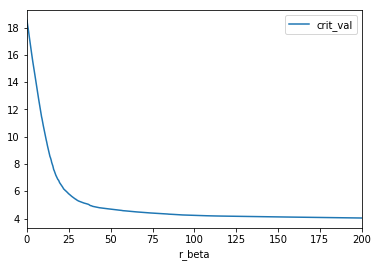

In [4]:
crit_val_95.plot(x='r_beta', y='crit_val')
plt.show()

## Question 4

In [9]:
k = 4
MC = 5000

r_beta = np.arange(0, 200.25, 0.25)

crit_val_95 = pd.DataFrame({'r_beta' : [], 'crit_val' : []})

for r in r_beta:
    np.random.seed(1211)
    vidle_1 = np.random.chisquare(df=1, size=([MC, 1]))
    vidle_k = np.random.chisquare(df=k - 1, size=([MC, 1]))
    
    LR = 0.5 * (vidle_k + vidle_1 - r + np.sqrt((vidle_k + vidle_1 + r) ** 2 - 4 * r * vidle_k))
    
    LR_crit_val = np.percentile(LR, q=95, interpolation='higher')
    
    
    
    crit_val_95 = crit_val_95.append(pd.DataFrame({'r_beta' : [r], 'crit_val' : [LR_crit_val]}), ignore_index=True)
    


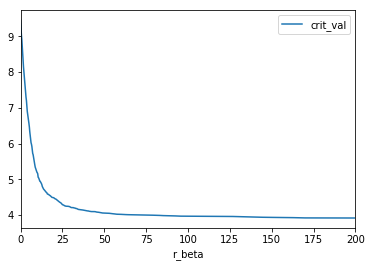

In [10]:
crit_val_95.plot(x='r_beta', y='crit_val')
plt.show()

## Question 5

In [11]:
data = pd.read_csv('dest.csv', 
                header=None, 
                names=['age', 'age2', 'ed',
                       'exper', 'exper2', 'nearc2',
                       'nearc4', 'nearc4a', 'nearc4b',
                       'race', 'smsa', 'south', 'wage'])